## Selecting Dataset

I would like to solve an image classification problem with deep learning. Last year I took Machine Learning from Data and we did a lot of classification work on images of handwritten digits. I don't want to use the same dataset, so I want to work on classifiying letters from images, which should be a harder problem, due to letters having more classes and a larger similarity between letters, such as 'b, d, p, q' and 'm, w, u, n' all having similar physical features.

I found EMNIST, which is an extension of the popular MNIST data set of handwritten digits, that includes letters in 28x28 image format. Tensorflow has a dataset loader for EMNIST in the tensorflow_datasets python package. The dataset is described here: https://www.nist.gov/itl/products-and-services/emnist-dataset

## Deep Learning Framework Selection

Since I am already using the tensorflow dataset library, it would also make sense to use tensorflow for the deep learning portion of my project. I am also using numpy as it allows for easy and fast calculations in my project.

In [25]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

Within the tensorflow library, I am using the Keras deep learning api, which is integrated into tensorflow. For most of the refrence for learning the library, I am using the official Tensorflow documentation found here: https://www.tensorflow.org/api_docs/python/tf and here https://www.tensorflow.org/api_docs/python/tf/keras

## Exploratory Data Analysis

The data consists of 103,600 28x28 pixel grayscale images, with 26 classes of images, representing the letters of the alphabet. The dataset info below lists 37 classes, which represent the 26 training classes and 19 test classes.

In [26]:
# Construct a tf.data.Dataset
ds_train, ds_dev = tfds.load('emnist/letters', split=['train[:90%]', 'train[90%:]'], as_supervised=True, shuffle_files=True)
ds_test, ds_info = tfds.load('emnist/letters', split='test', as_supervised=True, shuffle_files=True, with_info=True)
ds_info

tfds.core.DatasetInfo(
    name='emnist',
    version=3.0.0,
    description='The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.',
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
    }),
    total_num_examples=103600,
    splits={
        'test': 14800,
        'train': 88800,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{cohen_afshar_tapson_schaik_2017,
        title={EMNIST: Extending MNIST to handwritten letter

Example images from the dataset. Images are rotated horizontally flipped and rotated 90 degrees. I have also verified that both ds_train and ds_dev contain images from all 26 classes.

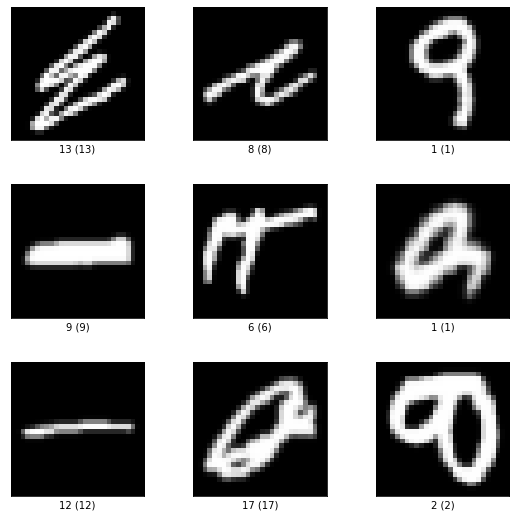

In [27]:
fig = tfds.show_examples(ds_test, ds_info)

However, I do am not running a convolutional nerual network, and do not want to have 28x28 = 784 input nodes, so I will be feature transforming the images into 1d augmented arrays using custom features.

Feature 0:
Augmented 1

Feature 1: Horizontal Symmetry-
Comparisons of [0:n/2] to [n/2:n] slices of the image and then averaged for each row

Feature 2: Vertical Symmetry-
Same as above but with columns.

Feature 3: Inverse Intensity-
For all pixels (256-grayscale value), averaged among all pixels.

In [28]:
def h_sym(image):
  sym = 0.0
  image = image.T[0]
  for i in range(len(image)):
    sym += np.average(image[i][0:len(image)//2] - image[i][len(image)//2: len(image)])
  return sym/image.shape[0]

def v_sym(image):
  sym = 0.0
  image = image.T[0].T
  for i in range(len(image)):
    sym += np.average(image[i][0:len(image)//2] - image[i][len(image)//2: len(image)])
  return sym/image.shape[0]

def intensity(image):
  return np.average(image.flatten())

def f_transform(image):
  image = image.numpy()
  return 1.0, h_sym(image), v_sym(image), intensity(image)

ds_dev_f = ds_dev.map(lambda data, label: (tf.py_function(f_transform, inp=[data], Tout=[tf.float32, tf.float32, tf.float32, tf.float32]), label))
ds_train_f = ds_train.map(lambda data, label: (tf.py_function(f_transform, inp=[data], Tout=[tf.float32, tf.float32, tf.float32, tf.float32]), label))
ds_test_f = ds_test.map(lambda data, label: (tf.py_function(f_transform, inp=[data], Tout=[tf.float32, tf.float32, tf.float32, tf.float32]), label))

In [29]:
x_train, y_train = [], []
for data, label in ds_train_f:
  if label in [1, 12, 13, 26]:
    x_train.append(data)
    y_train.append(label - 1)
x_test, y_test = [], []
for data, label in ds_test_f:
  if label in [1, 12, 13, 26]:
    x_test.append(data)
    y_test.append(label - 1)
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train, dtype=tf.uint8)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test, dtype=tf.uint8)

In [30]:
print(len(x_train))
print(x_train[0])
print(y_train[0])

print(x_train.shape, y_train.shape)

12275
tf.Tensor([ 1.       38.668365 54.59694  26.397959], shape=(4,), dtype=float32)
tf.Tensor(12, shape=(), dtype=uint8)
(12275, 4) (12275,)


## Model Implementation

In [31]:
# Hyper parameters
epochs = 10
batches = 1000
batch_size = int(len(ds_train)/batches)
fc1_nodes, fc2_nodes = 49, 49
output_classes = 26

In [32]:
# Defining forward propogation for the model

model = tf.keras.Sequential([
                             tf.keras.Input(shape=(4)),
                             tf.keras.layers.Dense(fc1_nodes, activation='relu'),
                             tf.keras.layers.Dense(fc2_nodes, activation='relu'),
                             tf.keras.layers.Dense(output_classes, activation='softmax')
])

model.summary()

Model: "sequential_2451"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7353 (Dense)           (None, 49)                245       
_________________________________________________________________
dense_7354 (Dense)           (None, 49)                2450      
_________________________________________________________________
dense_7355 (Dense)           (None, 26)                1300      
Total params: 3,995
Trainable params: 3,995
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=100)

Epoch 1/100
156/156 [==============================] - 0s 1ms/step - loss: 1.4150 - accuracy: 0.5500
Epoch 2/100
156/156 [==============================] - 0s 1ms/step - loss: 0.8757 - accuracy: 0.6294
Epoch 3/100
156/156 [==============================] - 0s 1ms/step - loss: 0.8554 - accuracy: 0.6365
Epoch 4/100
156/156 [==============================] - 0s 1ms/step - loss: 0.8455 - accuracy: 0.6389
Epoch 5/100
156/156 [==============================] - 0s 1ms/step - loss: 0.8215 - accuracy: 0.6496
Epoch 6/100
156/156 [==============================] - 0s 1ms/step - loss: 0.8071 - accuracy: 0.6524
Epoch 7/100
156/156 [==============================] - 0s 1ms/step - loss: 0.8037 - accuracy: 0.6516
Epoch 8/100
156/156 [==============================] - 0s 1ms/step - loss: 0.7968 - accuracy: 0.6522
Epoch 9/100
156/156 [==============================] - 0s 1ms/step - loss: 0.7811 - accuracy: 0.6598
Epoch 10/100
156/156 [==============================] - 0s 1ms/step - loss: 0.7827 - accura

In [34]:
model.evaluate(x_test, y_test, verbose=0)

[0.7579846978187561, 0.6604166626930237]

## Hyperparameter selection

To determine the number of epochs to run the model for, I tested a number of different values from 10 to 1000 to determine around when the model stopped improving the accuracy.

To determine the batch size, I kinda just estimated that 1000 batches is enough to be considered mini-batches.

To determine the optimal hidden layers, I ran the following code overnight to produce the best layer size.

I used the adam optimizer, which is built into the keras package since I found that it approached the best accuracy of the model faster than Stochastic Gradient Descent.

I didn't use a regularizer since I was not worried about overfitting in this model, but was more worried about underfitting. If I was using a CNN, I would consider using a regularizer. 

In [35]:
# b_acc, b_f1, b_f2 = 0, 0, 0
# for f1 in range(1, 100):
#   print(f1)
#   for f2 in range(1, 100):
#     modelt = tf.keras.Sequential([
#                                  tf.keras.Input(shape=(4)),
#                                  tf.keras.layers.Dense(f1, activation='relu'),
#                                  tf.keras.layers.Dense(f2, activation='relu'),
#                                  tf.keras.layers.Dense(output_classes, activation='softmax')
#                                  ])
#     modelt.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])
#     modelt.fit(x_train, y_train, batch_size=batch_size, epochs=10, verbose=0)
#     output = modelt.evaluate(x_test, y_test, verbose=0)
#     if output[1] > b_acc:
#       b_f1, b_f2 = f1, f2
# print(b_f1, b_f2)